# Detección de Esquinas y Flujo Óptico

En esta práctica, se estudiarán las numerosas técnicas utilizadas para calcular el flujo óptico en una película o secuencia de fotogramas. Se repasará la teoría esencial y la implementación de las técnicas de flujo óptico disperso y denso en OpenCV.

#### Importar librerías y funciones auxiliares

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')

def plot_img(images, titles):
  fig, axs = plt.subplots(nrows = 1, ncols = len(images), figsize = (15, 15))
  for i, p in enumerate(images):
    axs[i].imshow(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])
    axs[i].axis('off')
  plt.show()

## Detección de Esquinas

Una <b>esquina</b> se define como el punto en el que confluyen dos aristas. Una esquina puede describirse alternativamente como un lugar con dos orientaciones de borde dominantes y opuestas en su entorno local. Un <b>punto de interés</b> es un punto en una imagen con una posición bien definida que puede detectarse de forma fiable. Esto implica que un punto de interés puede ser una esquina, pero también puede ser un punto aislado de mayor o menor intensidad local, una línea que termina, o un punto en una curva donde la curvatura es localmente máxima. En la práctica, la mayoría de los llamados algoritmos de detección de esquinas descubren los puntos de interés en general, y los términos <b>esquina</b> y <b>punto de interés</b> se utilizan indistintamente en todo el ámbito.

<center><img src='Recursos\DefEsquinas.png' width=400></center>

La detección de esquinas es una técnica utilizada en los sistemas de visión por ordenador para extraer ciertas características e inferir el contenido de una imagen. La detección de esquinas se utiliza habitualmente en la detección de movimiento, el registro de imágenes, el seguimiento de vídeos, la creación de mosaicos de imágenes, el cosido panorámico, la reconstrucción 3D y el reconocimiento de objetos.

<center><img src='Recursos\DetEsquinas.jpg' width=300></center>

### Detector de Esquinas de Harris

Chris Harris y Mike Stephens hicieron un primer intento de localizar estas esquinas en su artículo <i>A Combined Corner and Edge Detector</i> <a href src='http://www.bmva.org/bmvc/1988/avc-88-023.pdf'>[1]</a> (Detector combinado de esquinas y bordes) en 1988, que ahora se conoce como el detector de esquinas de Harris. Convirtió este concepto básico en una fórmula matemática. Simplemente encuentra la diferencia de intensidad para un desplazamiento $(u,v)$ en todas las direcciones. La fórmula es la siguiente:

$E(u,v)=\sum_{x,y}^{}\underset{\overbrace{Funcion\space de\space ventana}}{w(x,y)}\space[\underset{\overbrace{Intensidad\space desplazada}}{I(x+u, y+v)} - \underset{\overbrace{Intensidad}}{I(x,y)}]^2$

La función de ventana es un rectángulo o una ventana gaussiana que asigna pesos a los píxeles que se encuentran debajo de ella. Para la detección de esquinas, debemos maximizar la función $E(u,v)$. Esto implica que debemos maximizar el segundo término. Para esto, se utiliza implicitamente el algoritmo de `cv2.Sobel()` para encontrar los máximos locales de la imagen mediante sus derivadas.

#### Detector de esquinas Harris en OpenCV

OpenCV tiene la función `cv2.cornerHarris()` para este propósito.

##### Sintaxis de Función

``` python
dst = cv2.cornerHarris(src, blockSize, ksize, k)
```

`dst`: Imagen para almacenar las respuestas del detector Harris. Tiene el tipo `CV_32FC1` y el mismo tamaño que src .<br>

La función tiene **4 argumentos de entrada requeridos**:
<ol>
<li><code>src</code>: Entrada de imagen de 8 bits o de punto flotante de un solo canal. Es un argumento <b>obligatorio</b>.
<br>
<li><code>blockSize</code>: Tamaño de la vecindad. Para cada píxel (x,y) calcula una matriz de gradiente 2×2 M(x,y) sobre una vecindad <code>blockSize×blockSize</code>. Es un argumento <b>obligatorio</b>.
<br>
<li><code>ksize</code>: Parámetro de apertura del operador Sobel. Es un argumento <b>obligatorio</b>.
<li><code>k</code>: Parámetro libre del detector Harris. Es un argumento <b>obligatorio</b>.
</ol>

A continuación se realiza un ejemplo para demostrar el procedimiento para encontrar las esquinas en base al algoritmo de detección de esquinas de Harris.

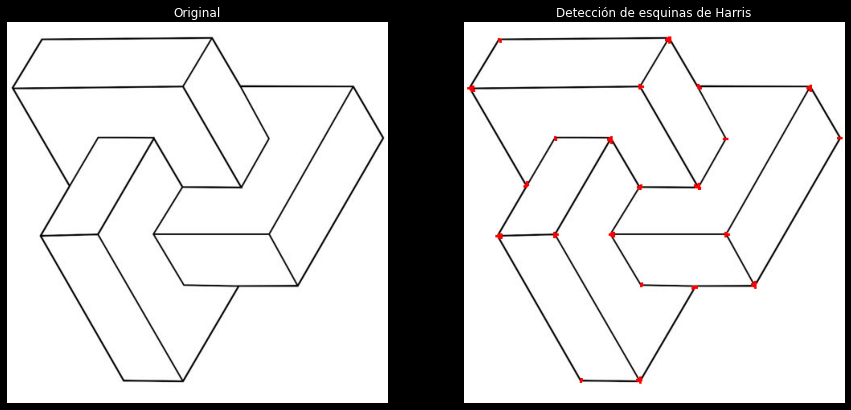

In [2]:
img = cv2.imread('Recursos/Shape.png', cv2.IMREAD_COLOR)

img_op = img.copy()
# convertir la imagen de entrada en espacio de color en escala de grises
gray = cv2.cvtColor(img_op, cv2.COLOR_BGR2GRAY)

# modificar la configuración del tipo de datos a punto flotante de 32 bits
gray = np.float32(gray)  # type: ignore

#aplicar el método cv2.cornerHarris para detectar las esquinas
dst = cv2.cornerHarris(gray, 2, 3, 0.04)  # type: ignore

# dilatar puntos de esquinas para que sean mas visibles
dst = cv2.dilate(dst, None)

# Umbral para un valor óptimo, puede variar dependiendo de la imagen.
img_op[dst>0.01*dst.max()]=[0,0,255]

imagenes = [img, img_op]
titulos = ['Original', 'Detección de esquinas de Harris']

plot_img(imagenes, titulos)

### Detector de esquinas Shi-Tomasi y <i>Good Features to Track</i>

Más tarde, en 1994, J. Shi y C. Tomasi introdujeron una pequeña modificación en su artículo <i>Good Features to Track</i>, que muestra mejores resultados en comparación con el detector de esquinas de Harris. Aquí la intuición básica es que las esquinas pueden detectarse buscando un cambio significativo en todas las direcciones. Consideramos una pequeña ventana en la imagen y luego escaneamos toda la imagen en busca de esquinas. Si se desplaza esta pequeña ventana en cualquier dirección, se producirá un gran cambio en la apariencia, si esa ventana concreta se encuentra en una esquina.

#### Detector de esquinas Shi-Tomasi en OpenCV

OpenCV tiene la función `cv2.goodFeaturesToTrack()` para este propósito.

##### Sintaxis de Función

``` python
corners = cv2.goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance)
```

`corners`: Vector de salida de esquinas detectadas.<br>

La función tiene **4 argumentos de entrada requeridos**:
<ol>
<li><code>image</code>: Entrada de 8 bits o punto flotante de 32 bits, imagen de un solo canal. Es un argumento <b>obligatorio</b>.
<br>
<li><code>maxCorners</code>: El número máximo de esquinas que se pueden devolver. Si se detectan más esquinas de las que se encuentran, se devuelve la más fuerte. maxCorners <= 0 indica que no se especifica ningún límite máximo y que se devuelven todas las esquinas detectadas. Es un argumento <b>obligatorio</b>.
<br>
<li><code>qualityLevel</code>: Parámetro que caracteriza la calidad mínima aceptada de las esquinas de la imagen. Es un argumento <b>obligatorio</b>.
<br>
<li><code>minDistance</code>: Mínima distancia euclidiana posible entre las esquinas devueltas. Es un argumento <b>obligatorio</b>.
</ol>

La técnica Shi-Tomasi se utiliza para descubrir las $N$ esquinas más fuertes de una imagen. Como es habitual, la imagen debe estar en escala de grises. A continuación, se define el número de esquinas que se desea localizar. El nivel de calidad, que es un número entre 0 y 1, define la calidad mínima de la esquina por debajo de la cual se rechazan todas. A continuación, se proporciona la menor distancia euclidiana entre esquinas descubiertas.

Con toda esta información, la función localiza las esquinas de la imagen. Todas las esquinas que están por debajo de un determinado estándar de calidad se descartan. Las esquinas restantes se clasifican en orden descendente en función de la calidad. A continuación, la función toma la primera esquina más fuerte, descarta las esquinas circundantes dentro del rango de distancia mínima y devuelve las N esquinas más fuertes.

En el siguiente ejemplo, intentaremos encontrar las 5 mejores esquinas:

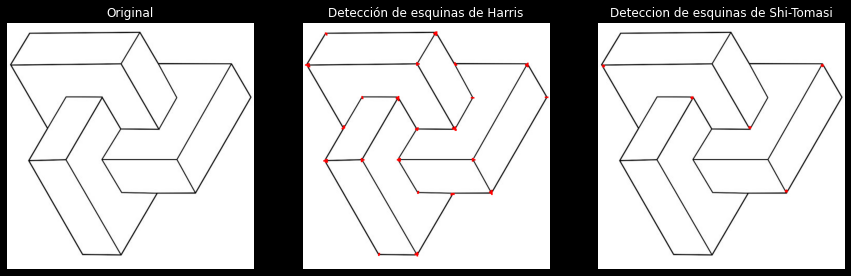

In [31]:
img_op_g = img.copy()
# convertir la imagen de entrada en espacio de color en escala de grises
gray = cv2.cvtColor(img_op_g, cv2.COLOR_BGR2GRAY)

#aplicar el método cv2.goodFeaturesToTrack para detectar las esquinas
corners = cv2.goodFeaturesToTrack(gray, 5, 0.01, 10)
corners = np.int32(corners)

for x, y in corners.reshape(-1, 2):  # type: ignore
    cv2.circle(img_op_g,(x, y),3, (0,0,255), cv2.FILLED)

imagenes.append(img_op_g)
titulos.append('Deteccion de esquinas de Shi-Tomasi')

plot_img(imagenes, titulos)

## Flujo Óptico

El flujo óptico surge del problema de estimar el movimiento por píxel entre dos cuadros sucesivos de un video. El trabajo de Optical Flow implica calcular el vector de desplazamiento de un píxel como una diferencia en el desplazamiento del objeto entre dos imágenes cercanas. La idea principal del flujo óptico es determinar el vector de desplazamiento de un elemento inducido por el movimiento o los movimientos de la cámara. El flujo óptico puede emplearse en diversas aplicaciones en las que la información sobre el movimiento de los objetos es fundamental. El flujo óptico se utiliza a menudo en los editores de vídeo para la compresión, la estabilización y los efectos de cámara lenta, entre otras cosas. El flujo óptico también se utiliza en actividades de reconocimiento de acciones y sistemas de seguimiento en tiempo real.

<center><img src='Recursos/Flow.jpg'></center>

Empecemos con una visión general del flujo óptico. El flujo óptico es el movimiento de los objetos entre fotogramas sucesivos de una serie producido por el movimiento relativo del objeto y la cámara. El problema del flujo óptico puede enunciarse como sigue:

<center><img src='Recursos\DefFlujoOpt.png'></center>

Podemos expresar la intensidad de la imagen (I) como una función del espacio $(x,y)$ y del tiempo $t$ entre los fotogramas siguientes. En otras palabras, obtenemos la nueva imagen $I(x+\delta x,y+\delta y,t+\delta t)$ desplazando $t$ veces los píxeles de la primera imagen $I(x,y,t)$.

Primero se asume que la intensidad de los pixeles para un objeto se mantiene constante entre los cuadros consecutivos.

$I(x, y, t) = I(x+\delta x,y+\delta y,t+\delta t)$

En segundo lugar, tomamos la aproximación de la serie de Taylor del lado derecho y eliminamos los términos comunes.

$I(x, y, t) - I(x+\delta x,y+\delta y,t+\delta t) = 0$

como

$I_x'u + I_y'v = -I_t'$

donde
$u=\frac{dx}{dt}$ y $v=\frac{dy}{dt}$

Los gradientes de la imagen a lo largo de los ejes horizontal, vertical y temporal están representados por $I_x'$, $I_y'$ y $I_t'$. Como resultado, terminamos con el problema del flujo óptico, o la determinación del movimiento a través del tiempo. Como sólo hay una ecuación para dos variables desconocidas, no podemos simplemente resolver la ecuación de flujo óptico para $u$ y $v$.

### Flujo óptico disperso y denso

Existen dos tipos de flujo óptico, el primero de los cuales se denomina <b>flujo óptico disperso</b>. Este calcula el vector de movimiento para un conjunto específico de objetos (por ejemplo, las esquinas detectadas en la imagen). Por lo tanto, requiere un preprocesamiento para extraer características de la imagen, que serán la base para el cálculo del flujo óptico. OpenCV proporciona algunas implementaciones de algoritmos para resolver la tarea de flujo óptico disperso:

<ul>
<li>Pirámide Lucas-Kanade
<li>RLOF disperso
</ul>

Utilizar sólo un conjunto de características dispersas significa que no tendremos la información de movimiento de los píxeles que no están contenidos en él. Esta restricción puede eliminarse utilizando algoritmos de flujo óptico denso que se supone que calculan un vector de movimiento para cada píxel de la imagen. Algunos algoritmos de flujo óptico denso ya están implementados en OpenCV:

<ul>
<li>Dense Pyramid Lucas-Kanade
<li>Farneback
</ul>

### Flujo óptico disperso en OpenCV

Para calcular el flujo óptico de una colección de características dispersas, se utiliza ampliamente el enfoque Lucas-Kanade. La noción principal de este enfoque se basa en la suposición de la constancia del movimiento local, en la que los píxeles vecinos tienen la misma dirección de desplazamiento. Esta suposición ayuda a obtener una solución aproximada al problema con dos variables.<br>
Los métodos calculan el vector de movimiento para el conjunto de características dispersas, de ahí que se utilice habitualmente el detector de esquinas de Shi-Tomasi. Se utiliza para localizar las esquinas en una imagen y luego calcular el vector de movimiento de esas esquinas entre dos fotogramas sucesivos.

<center><img src='Recursos/FlujoOpt.jpg' width=500></center>

Todo esto lo proporciona OpenCV en una sola función, `cv2.calcOpticalFlowPyrLK()`. En esta sección, construiremos una aplicación básica que monitorizará varios momentos de un video. Utilizamos `cv2.goodFeaturesToTrack()` para determinar los puntos.

#### Sintaxis de Función

``` python
nextPts, status, err = cv2.calcOpticalFlowPyrLK(prevImg, nextImg, prevPts, nextPts, **lk_params)
```

`nextPts`: El vector de salida de puntos 2D (con coordenadas de punto flotante de precisión única) que contiene las nuevas ubicaciones calculadas de las características de entrada en la segunda imagen; cuando se proporciona la bandera `OPTFLOW_USE_INITIAL_FLOW`, el vector debe tener el mismo tamaño que la entrada.<br>
`status`: Cada miembro del vector se pone a 1 si se ha determinado el flujo para las características relevantes, de lo contrario se pone a 0.<br>
`err`: Cada miembro del vector se establece en un error para la característica relevante; el tipo de la medida de error se puede especificar en el parámetro `flags`; si el flujo no fue identificado, el error no se crea (se utiliza el parámetro `status` para encontrar tales casos).

La función tiene **3 argumentos de entrada requeridos** y **arametros que se deben de configurar para el flujo óptico**:
<ol>
<li><code>prevImg</code>: Primera imagen de entrada de 8 bits o pirámide construida por <code>buildOpticalFlowPyramid</code>. Es un argumento <b>obligatorio</b>.
<br>
<li><code>nextImg</code>: Segunda imagen de entrada o pirámide del mismo tamaño y del mismo tipo que <code>prevImg</code>. Es un argumento <b>obligatorio</b>.
<br>
<li><code>prevPts</code>: vector de puntos 2D para los que se necesita encontrar el flujo; las coordenadas de los puntos deben ser números de punto flotante de precisión simple. Es un argumento <b>obligatorio</b>.
<br>
<li><code>nextPts</code>: El vector de salida de puntos 2D (con coordenadas de punto flotante de precisión única) que contiene las nuevas ubicaciones calculadas de las características de entrada en la segunda imagen. Es un argumento <b>obligatorio</b>.
<li><code>lk_params</code>: Parametros de configuración para el algoritmo. Es un argumento <b>obligatorio</b>.
</ol>

Comenzamos con el primer fotograma, encontramos varios puntos de esquina Shi-Tomasi en él, y luego rastreamos esos puntos repetidamente usando el flujo óptico Lucas-Kanade. Enviamos el fotograma anterior, los puntos anteriores y el fotograma futuro al método `cv2.calcOpticalFlowPyrLK()`. Éste devuelve los puntos siguientes así como varios números de estado, con un valor de 1 si el punto siguiente está localizado y cero en caso contrario. En la siguiente etapa, pasamos iterativamente estos próximos puntos como puntos previos.

### Flujo óptico denso en OpenCV

El flujo óptico denso trata de encontrar el vector de flujo óptico para cada píxel en cada fotograma. Aunque este método es más lento, produce una salida más precisa y densa, lo que es ideal para aplicaciones como el aprendizaje de la estructura a partir del movimiento y la segmentación de vídeo. El flujo óptico denso puede implementarse de varias maneras. Para la implementación, utilizaremos la técnica Farneback, que es una de las más populares y la utilizada por OpenCV, mediante la función `cv2.calcOpticalFlowFarneback()`. Se basa en la técnica de Gunnar Farneback, que se describe en el artículo de 2003 de Gunnar Farneback "Two-Frame Motion Estimation Based on Polynomial Expansion".

<center><img src='Recursos\DenseOptFlow.jpg'></center>

#### Sintaxis de Función

``` python
flow = cv2.calcOpticalFlowFarneback(prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma)
```

`flow`: Imagen de flujo calculada que tiene el mismo tamaño que prev y el tipo CV_32FC2.<br>


La función tiene **9 argumentos de entrada requeridos**:
<ol>
<li><code>prev</code>: Primera imagen de entrada de 8 bits de un solo canal. Es un argumento <b>obligatorio</b>.
<br>
<li><code>next</code>: Segunda imagen de entrada del mismo tamaño y del mismo tipo que la anterior. Es un argumento <b>obligatorio</b>.
<br>
<li><code>flow</code>: Imagen de flujo calculada que tiene el mismo tamaño que prev y el tipo CV_32FC2. Es un argumento <b>obligatorio</b>.
<br>
<li><code>pyr_scale</code>: Especifica la escala de la imagen (<1) para construir pirámides para cada imagen; <code>pyr_scale=0.5</code> significa una pirámide clásica, donde cada capa siguiente es dos veces más pequeña que la anterior. Es un argumento <b>obligatorio</b>.
<li><code>levels</code>: Número de capas de la pirámide incluyendo la imagen inicial; <code>levels=1</code> significa que no se crean capas adicionales y sólo se utilizan las imágenes originales. Es un argumento <b>obligatorio</b>.
<li><code>winSize</code>: Tamaño de la ventana de promediación; los valores más grandes aumentan la robustez del algoritmo frente al ruido de la imagen y dan más posibilidades de detectar rápidamente el movimiento, pero producen un campo de movimiento más borroso. Es un argumento <b>obligatorio</b>.
<li><code>iterations</code>: Número de iteraciones que el algoritmo realiza en cada nivel de la pirámide. Es un argumento <b>obligatorio</b>.
<li><code>poly_n</code>: Tamaño de la vecindad de píxeles utilizada para encontrar la expansión polinómica en cada píxel; los valores más grandes significan que la imagen se aproximará con superficies más suaves, dando lugar a un algoritmo más robusto y a un campo de movimiento más borroso, normalmente <code>poly_n =5</code> o <code>7</code>. Es un argumento <b>obligatorio</b>.
<li><code>poly_sigma</code>: Desviación estándar de la gaussiana que se utiliza para suavizar las derivadas utilizadas como base para la expansión polinómica; para <code>poly_n=5</code>, se puede establecer <code>poly_sigma=1.1</code>, para <code>poly_n=7</code>, un buen valor sería <code>poly_sigma=1,5</code>. Es un argumento <b>obligatorio</b>.
</ol>

En este enfoque, obtenemos una matriz de 2 canales con vectores de flujo óptico $(u,v)$. Determinamos su tamaño y dirección. Codificamos por colores el resultado para que sea más fácil de ver. La dirección de la imagen se correlaciona con su valor de tono. La magnitud se relaciona con el plano de valor.

## Ejercicios

<ol>
<li>
Diseñar un programa en Python en el cual se cumplan los siguientes requisitos:
    <ul>
    <li>Cargar una video desde el disco duro.
    <li>Encontrar las esquinas en una secuencia de video. Dibujar un círculo alrededor de cada esquina encontrada
    <li>Aplicar el flujo óptico de Lucas-Kanade sobre los puntos encontrados.
    <li>Mostrar el movimiento mediante el uso de lineas de color sobre la secuencia original.
    </ul>
</li>
<br>
<li>
Diseñar un programa en Python en el cual se cumplan los siguientes requisitos:
    <ul>
    <li>Acceder a la cámara web.
    <li>Aplicar el flujo óptico denso de Gunnar Farneback.
    <li>Mostrar el movimiento mediante el uso de color en una ventana.
    </ul>
</li>
</ol>